In [1]:
# This Python 3 environment comes with many helpful analytics libraries installed
# It is defined by the kaggle/python Docker image: https://github.com/kaggle/docker-python
# For example, here's several helpful packages to load

import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)

# Input data files are available in the read-only "../input/" directory
# For example, running this (by clicking run or pressing Shift+Enter) will list all files under the input directory

import os
for dirname, _, filenames in os.walk('/kaggle/input'):
    for filename in filenames:
        print(os.path.join(dirname, filename))

# You can write up to 20GB to the current directory (/kaggle/working/) that gets preserved as output when you create a version using "Save & Run All" 
# You can also write temporary files to /kaggle/temp/, but they won't be saved outside of the current session

# Importing The Required Libraries

In [2]:
import torch
import torch.nn as nn
import matplotlib.pyplot as plt
%matplotlib inline


from qiskit import Aer, QuantumCircuit
from qiskit.utils import QuantumInstance, algorithm_globals
from qiskit.opflow import AerPauliExpectation
from qiskit.circuit import Parameter
from qiskit.circuit.library import RealAmplitudes, ZZFeatureMap
from qiskit_machine_learning.neural_networks import CircuitQNN, TwoLayerQNN
from qiskit_machine_learning.connectors import TorchConnector


<frozen importlib._bootstrap>:219: RuntimeWarning: scipy._lib.messagestream.MessageStream size changed, may indicate binary incompatibility. Expected 56 from C header, got 64 from PyObject


In [3]:
df1 = pd.read_csv('Iris.csv')

In [4]:
df1.head()

,Id,SepalLengthCm,SepalWidthCm,PetalLengthCm,PetalWidthCm,Species
0,1,5.1,3.5,1.4,0.2,Iris-setosa
1,2,4.9,3.0,1.4,0.2,Iris-setosa
2,3,4.7,3.2,1.3,0.2,Iris-setosa
3,4,4.6,3.1,1.5,0.2,Iris-setosa
4,5,5.0,3.6,1.4,0.2,Iris-setosa


# Creating A Function To Get The Details of The Dataset

In [5]:
def get_info_dataframe(dataframe):
    print(f"DATAFRAME GENERAL INFO - \n")
    print(dataframe.info(),"\n")
    print(f"DATAFRAME MISSING INFO - \n")
    print(dataframe.isnull().sum(),"\n")
    print(f"DATAFRAME SHAPE INFO - \n")
    print(dataframe.shape)

In [6]:
get_info_dataframe(df1)

DATAFRAME GENERAL INFO - 

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 150 entries, 0 to 149
Data columns (total 6 columns):
 #   Column         Non-Null Count  Dtype  
---  ------         --------------  -----  
 0   Id             150 non-null    int64  
 1   SepalLengthCm  150 non-null    float64
 2   SepalWidthCm   150 non-null    float64
 3   PetalLengthCm  150 non-null    float64
 4   PetalWidthCm   150 non-null    float64
 5   Species        150 non-null    object 
dtypes: float64(4), int64(1), object(1)
memory usage: 7.2+ KB
None 

DATAFRAME MISSING INFO - 

Id               0
SepalLengthCm    0
SepalWidthCm     0
PetalLengthCm    0
PetalWidthCm     0
Species          0
dtype: int64 

DATAFRAME SHAPE INFO - 

(150, 6)


In [7]:
df1['Species'].unique()

array(['Iris-setosa', 'Iris-versicolor', 'Iris-virginica'], dtype=object)

# LabelEncoding The Attributes of The Target Column

In [8]:
df1['Species'] = df1['Species'].map({'Iris-setosa':0,'Iris-versicolor':1,'Iris-virginica':2})

In [9]:
df1.head()

,Id,SepalLengthCm,SepalWidthCm,PetalLengthCm,PetalWidthCm,Species
0,1,5.1,3.5,1.4,0.2,0
1,2,4.9,3.0,1.4,0.2,0
2,3,4.7,3.2,1.3,0.2,0
3,4,4.6,3.1,1.5,0.2,0
4,5,5.0,3.6,1.4,0.2,0


In [10]:
df1.drop(['Id'],axis=1,inplace=True)

In [11]:
df1.head()

,SepalLengthCm,SepalWidthCm,PetalLengthCm,PetalWidthCm,Species
0,5.1,3.5,1.4,0.2,0
1,4.9,3.0,1.4,0.2,0
2,4.7,3.2,1.3,0.2,0
3,4.6,3.1,1.5,0.2,0
4,5.0,3.6,1.4,0.2,0


In [12]:
X = df1.drop(["Species"],axis=1).values
y = df1["Species"].values

In [13]:
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import train_test_split

In [14]:
scaler = StandardScaler()

# Doing The Train Test Split And Scaling The Data

In [15]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.30, random_state=42)

In [16]:
X_train = scaler.fit_transform(X_train)
X_test = scaler.transform(X_test)

# Converting From Numpy Array To Torch Tensor

In [17]:
X_train = torch.FloatTensor(X_train)
X_test = torch.FloatTensor(X_test)
y_train = torch.LongTensor(y_train)
y_test = torch.LongTensor(y_test)

# Creating Our Neural Network Model For Classification

In [18]:
# declare quantum instance
qi = QuantumInstance(Aer.get_backend("aer_simulator_statevector"))

In [19]:
# input_dim = 4 because we have 4 inputs namely sepal_length,sepal_width,petal_length,petal_width
# output_dim = 3 because we have namely 3 categories setosa,versicolor and virginica
input_dim  = 4 
output_dim = 3

In [20]:
# Define and create QNN
def create_qnn():
    feature_map = ZZFeatureMap(2)
    ansatz = RealAmplitudes(2, reps=1)
    # REMEMBER TO SET input_gradients=True FOR ENABLING HYBRID GRADIENT BACKPROP
    qnn = TwoLayerQNN(
        2,
        feature_map,
        ansatz,
        input_gradients=True,
        exp_val=AerPauliExpectation(),
        quantum_instance=qi,
    )
    return qnn


qnn = create_qnn()
print(qnn.operator)

ComposedOp([
  OperatorMeasurement(1.0 * ZZ),
  CircuitStateFn(
       ┌──────────────────────────┐┌──────────────────────────────────────┐
  q_0: ┤0                         ├┤0                                     ├
       │  ZZFeatureMap(x[0],x[1]) ││  RealAmplitudes(θ[0],θ[1],θ[2],θ[3]) │
  q_1: ┤1                         ├┤1                                     ├
       └──────────────────────────┘└──────────────────────────────────────┘
  )
])


In [21]:
class NeuralNetworkClassificationModel(nn.Module):
    def __init__(self,input_dim,output_dim):
        super(NeuralNetworkClassificationModel,self).__init__()
        self.input_layer    = nn.Linear(input_dim,2)
        self.hidden_layer1  = TorchConnector(qnn)
        self.output_layer   = nn.Linear(1,output_dim)
        self.relu = nn.ReLU()
    
    
    def forward(self,x):
        out =  self.relu(self.input_layer(x))
        out =  self.relu(self.hidden_layer1(out))
        out =  self.output_layer(out)
        return out

In [22]:

model = NeuralNetworkClassificationModel(input_dim,output_dim)

In [23]:
# creating our optimizer and loss function object
learning_rate = 0.01
criterion = nn.CrossEntropyLoss()
optimizer = torch.optim.Adam(model.parameters(),lr=learning_rate)

In [24]:
def train_network(model,optimizer,criterion,X_train,y_train,X_test,y_test,num_epochs,train_losses,test_losses):
    for epoch in range(num_epochs):
        #clear out the gradients from the last step loss.backward()
        optimizer.zero_grad()
        
        #forward feed
        output_train = model(X_train)

        #calculate the loss
        loss_train = criterion(output_train, y_train)
        


        #backward propagation: calculate gradients
        loss_train.backward()

        #update the weights
        optimizer.step()

        
        output_test = model(X_test)
        loss_test = criterion(output_test,y_test)

        train_losses[epoch] = loss_train.item()
        test_losses[epoch] = loss_test.item()

        if (epoch + 1) % 50 == 0:
            print(f"Epoch {epoch+1}/{num_epochs}, Train Loss: {loss_train.item():.4f}, Test Loss: {loss_test.item():.4f}")

In [25]:
num_epochs = 1000
train_losses = np.zeros(num_epochs)
test_losses  = np.zeros(num_epochs)

In [26]:
train_network(model,optimizer,criterion,X_train,y_train,X_test,y_test,num_epochs,train_losses,test_losses)

Epoch 50/1000, Train Loss: 0.8569, Test Loss: 0.8835
Epoch 100/1000, Train Loss: 0.7393, Test Loss: 0.7743
Epoch 150/1000, Train Loss: 0.6841, Test Loss: 0.7240
Epoch 200/1000, Train Loss: 0.6483, Test Loss: 0.6860
Epoch 250/1000, Train Loss: 0.6188, Test Loss: 0.6704
Epoch 300/1000, Train Loss: 0.5911, Test Loss: 0.6574
Epoch 350/1000, Train Loss: 0.5714, Test Loss: 0.6539
Epoch 400/1000, Train Loss: 0.5549, Test Loss: 0.6429
Epoch 450/1000, Train Loss: 0.5460, Test Loss: 0.6386
Epoch 500/1000, Train Loss: 0.5370, Test Loss: 0.6397
Epoch 550/1000, Train Loss: 0.5296, Test Loss: 0.6416
Epoch 600/1000, Train Loss: 0.5106, Test Loss: 0.6150
Epoch 650/1000, Train Loss: 0.4933, Test Loss: 0.5850
Epoch 700/1000, Train Loss: 0.4608, Test Loss: 0.5475
Epoch 750/1000, Train Loss: 0.4492, Test Loss: 0.5478
Epoch 800/1000, Train Loss: 0.4399, Test Loss: 0.5371
Epoch 850/1000, Train Loss: 0.4313, Test Loss: 0.5317
Epoch 900/1000, Train Loss: 0.4234, Test Loss: 0.5254
Epoch 950/1000, Train Loss: 0

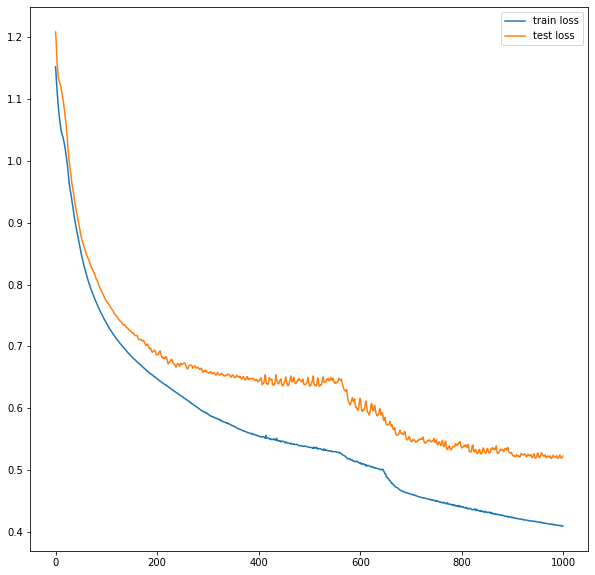

In [27]:
plt.figure(figsize=(10,10))
plt.plot(train_losses, label='train loss')
plt.plot(test_losses, label='test loss')
plt.legend()
plt.show()

In [28]:
predictions_train = []
predictions_test =  []
with torch.no_grad():
    predictions_train = model(X_train)
    predictions_test = model(X_test)

In [29]:
# Check how the predicted outputs look like and after taking argmax compare with y_train or y_test 
#predictions_train  
#y_train,y_test

In [30]:
def get_accuracy_multiclass(pred_arr,original_arr):
    if len(pred_arr)!=len(original_arr):
        return False
    pred_arr = pred_arr.numpy()
    original_arr = original_arr.numpy()
    final_pred= []
    # we will get something like this in the pred_arr [32.1680,12.9350,-58.4877]
    # so will be taking the index of that argument which has the highest value here 32.1680 which corresponds to 0th index
    for i in range(len(pred_arr)):
        final_pred.append(np.argmax(pred_arr[i]))
    final_pred = np.array(final_pred)
    count = 0
    #here we are doing a simple comparison between the predicted_arr and the original_arr to get the final accuracy
    for i in range(len(original_arr)):
        if final_pred[i] == original_arr[i]:
            count+=1
    return count/len(final_pred)

In [31]:
train_acc = get_accuracy_multiclass(predictions_train,y_train)
test_acc  = get_accuracy_multiclass(predictions_test,y_test)

In [32]:
print(f"Training Accuracy: {round(train_acc*100,3)}")
print(f"Test Accuracy: {round(test_acc*100,3)}")

Training Accuracy: 85.714
Test Accuracy: 88.889
